In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
detA = pd.read_csv("../data/DetectorA.csv", header=None, names=["event_id", "class_score", "energy"])
detB = pd.read_csv("../data/DetectorB.csv", header=None, names=["event_id", "class_score", "energy"])
detC = pd.read_csv("../data/DetectorC.csv", header=None, names=["event_id", "class_score", "energy"])
detTarget = pd.read_csv("../data/DetectorTarget.csv", header=None, names=["event_id", "class_score", "energy"])

In [5]:
detA.head()

,event_id,class_score,energy
0,734628.0,0.440,2123.514
1,229218.0,0.179,1017.985
2,428880.0,0.028,1862.961
3,1990.0,0.080,1619.836
4,55401.0,0.065,2611.720


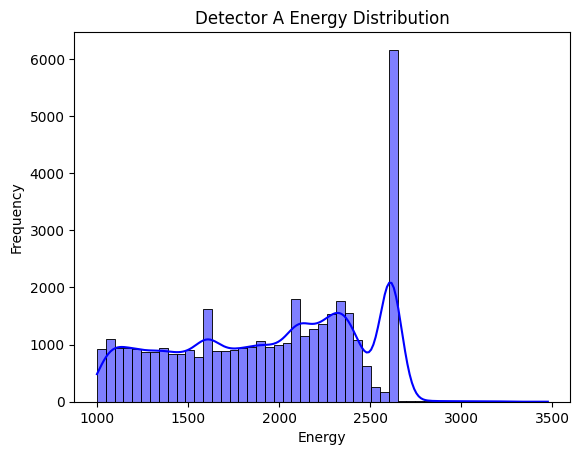

In [ ]:
sns.histplot(detA["energy"], kde=True, color="blue")
plt.title("Detector A Energy Distribution")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.show()

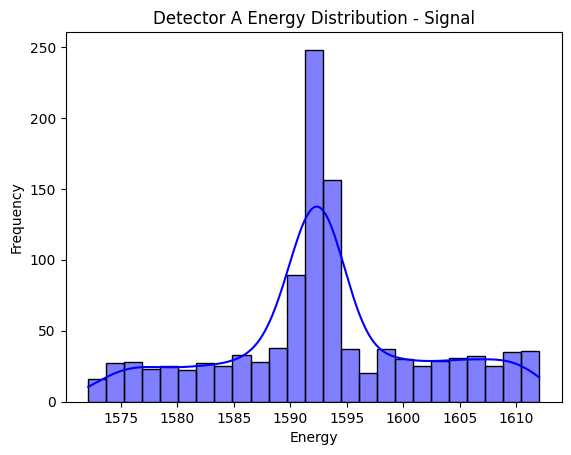

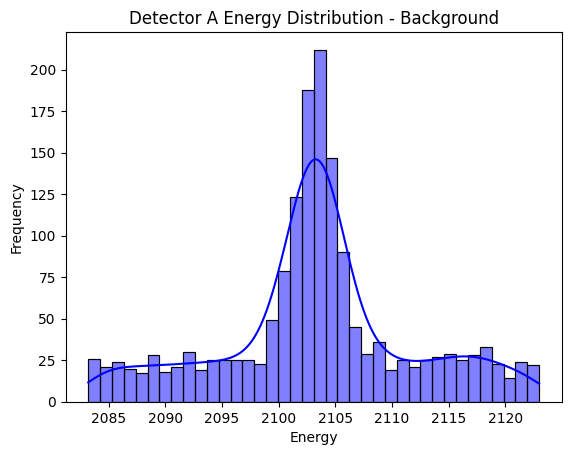

In [22]:
delta = 20
signal = 1592
background = 2103
A_signal = detA[(detA["energy"] >= signal - delta) & (detA["energy"] <= signal + delta)]
A_background = detA[(detA["energy"] >= background - delta) & (detA["energy"] <= background + delta)]

sns.histplot(A_signal["energy"], kde=True, color="blue")
plt.title("Detector A Energy Distribution - Signal")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.show()

sns.histplot(A_background["energy"], kde=True, color="blue")
plt.title("Detector A Energy Distribution - Background")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.show()

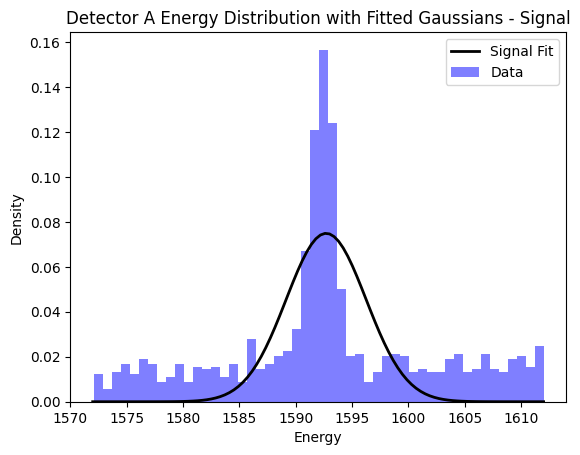

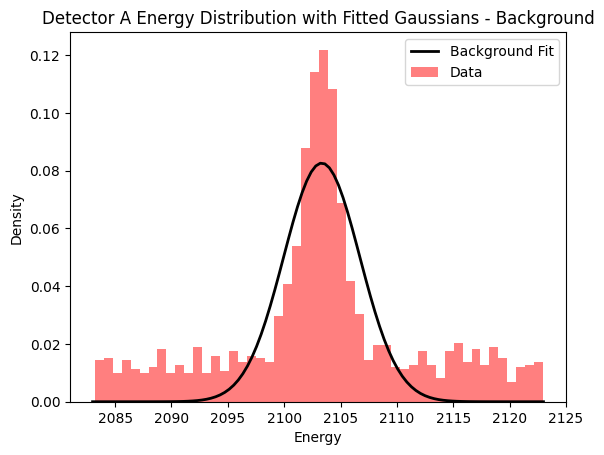

In [28]:
# fit gaussian to signal and background peaks
from scipy.stats import norm
mu_signal, std_signal = norm.fit(A_signal["energy"])
mu_background, std_background = norm.fit(A_background["energy"])

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


from scipy.optimize import curve_fit

p0 = [1., signal, 1.]

hist, bin_edges = np.histogram(A_signal["energy"], density=True)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

# plot fitted gaussian against true dists
xmin, xmax = signal - delta, signal + delta
x = np.linspace(xmin, xmax, 100)
p_signal = gauss(x, *coeff)
plt.plot(x, p_signal, 'k', linewidth=2, label='Signal Fit')
plt.hist(A_signal["energy"], bins=50, density=True, alpha=0.5, color='blue', label='Data')
plt.title("Detector A Energy Distribution with Fitted Gaussians - Signal")
plt.xlabel("Energy")
plt.ylabel("Density")
plt.legend()
plt.show()

p0 = [1., background, 1.]

hist, bin_edges = np.histogram(A_background["energy"], density=True)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
xmin, xmax = background - delta, background + delta
x = np.linspace(xmin, xmax, 100)
p_background = gauss(x, *coeff)
plt.plot(x, p_background, 'k', linewidth=2, label='Background Fit')
plt.hist(A_background["energy"], bins=50, density=True, alpha=0.5, color='red', label='Data')
plt.title("Detector A Energy Distribution with Fitted Gaussians - Background")
plt.xlabel("Energy")
plt.ylabel("Density")
plt.legend()
plt.show()

Kind of suggests Nate's initial guess of using +/- 6 is pretty good. I'll try with 8 for now to include more data.

Detector A - Best Threshold: 0.10101010101010102, TPR: 0.7593880389429764, FPR: 0.2619893428063943


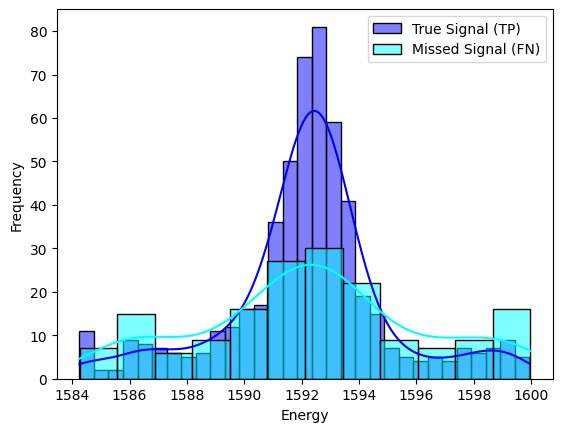

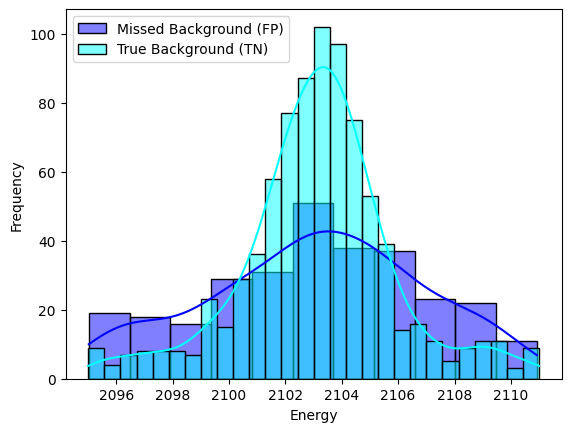

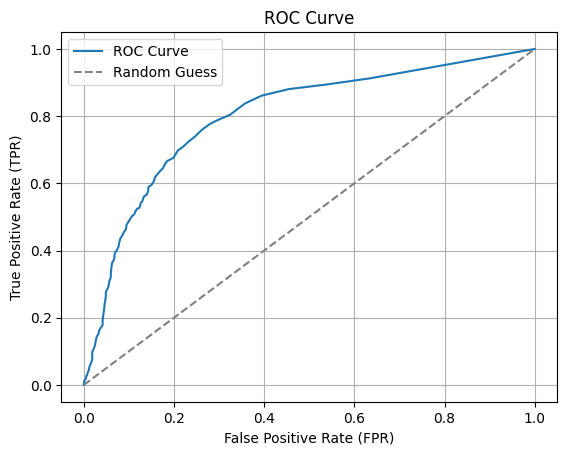

In [34]:
# determine your cutting threshold on detector A using both of its 1592 peak 
# (signal) and 2103 peak (background)
# perform baseline subtraction as needed

def threshold_calc(data, delta, name):
    tprs = []
    fprs = []
    signal = 1592
    background = 2103
    signal = data[(data["energy"] >= signal - delta) & (data["energy"] <= signal + delta)]
    background = data[(data["energy"] >= background - delta) & (data["energy"] <= background + delta)]

    best_tpr = 0
    best_fpr = 1
    best_threshold = 0
    thresholds = np.linspace(0, 1, 100)
    for threshold in thresholds:
        tp = np.sum((signal['class_score'] >= threshold))
        fp = np.sum((background['class_score'] >= threshold))
        fn = np.sum((signal['class_score'] < threshold))
        tn = np.sum((background['class_score'] < threshold))
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        tprs.append(tpr)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fprs.append(fpr)
        
        if tpr - fpr > best_tpr - best_fpr:
            best_tpr = tpr
            best_fpr = fpr
            best_threshold = threshold
    
    print(f"Detector {name} - Best Threshold: {best_threshold}, TPR: {best_tpr}, FPR: {best_fpr}")
    sns.histplot(signal[signal['class_score'] >= best_threshold]['energy'], color='blue', label='True Signal (TP)', kde=True)
    sns.histplot(signal[signal['class_score'] < best_threshold]['energy'], color='cyan', label='Missed Signal (FN)', kde=True)
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    sns.histplot(background[background['class_score'] >= best_threshold]['energy'], color='blue', label='Missed Background (FP)', kde=True)
    sns.histplot(background[background['class_score'] < best_threshold]['energy'], color='cyan', label='True Background (TN)', kde=True)
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    plt.plot(fprs, tprs, linestyle='-', label="ROC Curve")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold   

THRESHOLD = threshold_calc(detA, delta, 'A')
# threshold_calc(detB, delta, 'B')